In [3]:
import copy
import torch 
import matplotlib.pyplot as plt
from fmfts.experiments.dRTI.training_parameters import params
from fmfts.experiments.dRTI.models import (
    VelocityModelFullRTI3D, 
    DeterministicModelFullRTI3D, 
    DirectDistillationModelFullRTI3D
)
from fmfts.utils.models.add import AdversarialDiffusionDistillation
from fmfts.utils.models.cfm_rectifier import Rectifier
from fmfts.utils.models.cfm_prog_dist import ProgressiveDistillation

from fmfts.dataloader.dRTI import DatasetFullRTI3D

torch.set_grad_enabled(False)

# load all models
velocity = VelocityModelFullRTI3D(**params["velocity"]["model_kwargs"])
velocity.load_state_dict(torch.load("trained_models/VelocityModelFullRTI3D.pt", weights_only=True)["model"])
dirdist = DirectDistillationModelFullRTI3D(velocity_model = copy.deepcopy(velocity), **params["dir_dist"]["model_kwargs"])
dirdist.load_state_dict(torch.load("trained_models/DirectDistillationModelFullRTI3D.pt", weights_only=True)["model"])
det = DeterministicModelFullRTI3D(**params["deterministic"]["model_kwargs"])
det.load_state_dict(torch.load("trained_models/DeterministicModelFullRTI3D.pt", weights_only=True)["model"])
wgan = AdversarialDiffusionDistillation(velocity_model = copy.deepcopy(velocity))
wgan.load_state_dict(torch.load("trained_models/AdversarialDiffusionDistillation__lmbda_0.0.pt", weights_only=True)["model"])
add = AdversarialDiffusionDistillation(velocity_model = copy.deepcopy(velocity))
add.load_state_dict(torch.load("trained_models/AdversarialDiffusionDistillation__lmbda_0.9.pt", weights_only=True)["model"])
rfm = Rectifier(velocity_model = copy.deepcopy(velocity) )
rfm.load_state_dict(torch.load("trained_models/Rectifier__stage_2.pt", weights_only=True)["model"])
progdist = ProgressiveDistillation(velocity_model = copy.deepcopy(velocity), **params["prog_dist"]["model_kwargs"])
progdist.load_state_dict(torch.load("trained_models/ProgressiveDistillation__k_2__stage_1.pt", weights_only=True)["model"])

dataset_test = DatasetFullRTI3D(At=0.75, dt=5, dx=4, dy=4, dz=4, include_timestamp=True, mode="test")

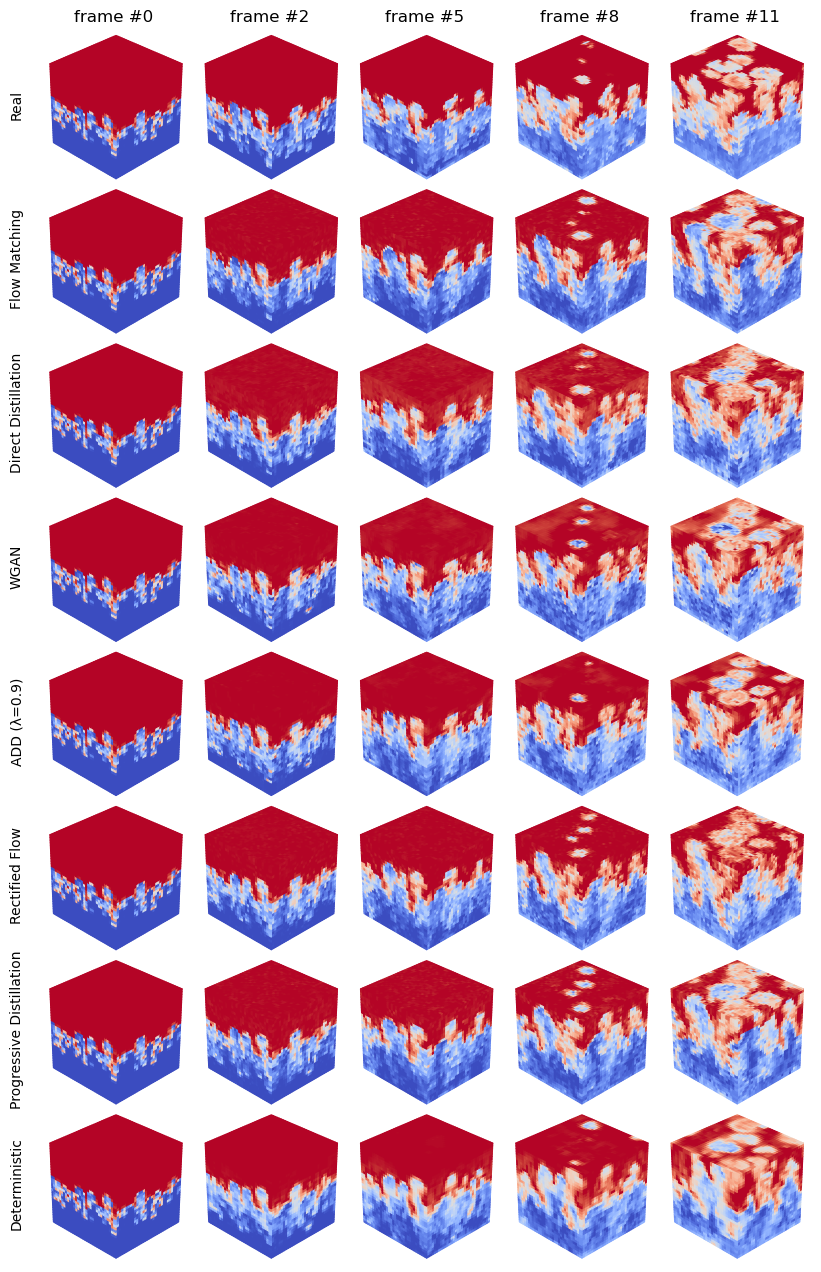

In [15]:
sequence_len = 14
n_plots = 5
Y_real = dataset_test.get(0, 50, sequence_len=sequence_len)

models = [ None, velocity, dirdist, wgan, add, rfm, progdist, det ]
labels = [ "Real", "Flow Matching", "Direct Distillation", "WGAN", "ADD (λ=0.9)", "Rectified Flow", "Progressive Distillation", "Deterministic" ]

# make predictions
Y = torch.zeros( len(models), sequence_len, *Y_real.shape[1:] ) # < contains all (generated) sequences
Y[:,0] = Y_real[0] # < initial condition
Y[0] = Y_real # < make sure the real trajectory is also stored at index 0
for i in range(sequence_len-1):
    for m, model in enumerate(models):
        if model is None: continue
        y = Y[m,i,None]
        x0 = velocity.p0.sample(y.shape).to(y.device)
        Y[m,i+1,None] = model.sample(y, x0=x0)

# plot results
fig, axes = plt.subplots(len(models), n_plots, figsize=(2*n_plots, 2*len(models)), subplot_kw={"projection": "3d"})
for m in range(len(models)):
    for p in range(n_plots):
        q = p * sequence_len // n_plots
        ax = axes[m,p] if len(models) > 1 else axes[p]
        dataset_test.plot(Y[m,q], ax)
        if p == 0: ax.text2D(-0.12, 0.0, labels[m], rotation = "vertical", horizontalalignment='center', verticalalignment='center')
        if m == 0: ax.set_title(f"frame #{q}")
        ax.set_axis_off()

fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()